## Accessing ALOS DEM data on Azure

The [ALOS World 3D-30m](https://www.eorc.jaxa.jp/ALOS/en/aw3d30/index.htm) DSM dataset is a 30 meter resolution global Digital Surface Model (DSM). The dataset is based on a 5 meter resolution dataset developed by the Japan Aerospace Exploration Agency (JAXA) since 2014, named "ALOS World 3D". The AW3D dataset was developed using 3 million scenes acquired by the PRISM panchromatic optical sensor on the Advanced Land Observing Satellite "DAICHI" (ALOS), operated from 2006 to 2011.

ALOS DEM is available on Azure in cloud-optimized GeoTIFF (COG) format; COG files were sourced from [OpenTopography](https://portal.opentopography.org/raster?opentopoID=OTALOS.112016.4326.2).

This notebook demonstrates access to ALOS DEM data from blob storage on Azure, including (1) finding the ALOS DEM tile corresponding to a lat/lon coordinate and (2) opening and plotting the tile.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-copernicus-dem](http://aka.ms/ai4edata-alos-dem).

You can also use the [Planetary Computer search API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) ([example](https://planetarycomputer.microsoft.com/dataset/alos-dem#Example-Notebook)) to search for ALOS DEM data.

### Imports and environment

In [3]:
import os
import math
import requests
import tempfile
import wget
import csv

import rasterio as rio
from rasterio import plot
from matplotlib import pyplot as plt

account_name = 'ai4edataeuwest'
container_name = 'alos-dem'
account_url = 'https://' + account_name + '.blob.core.windows.net'
blob_root = account_url + '/' + container_name + '/'

alos_dem_content_extension = '.tif'

# List of blobs and their lat/lon ranges, as left/bottom/right/top
alos_dem_extents_url = account_url + '/' + container_name + '/' + 'index/alos-dem-bounds.csv'

# Load the lat/lon table for the DEM
temp_dir = os.path.join(tempfile.gettempdir(),'alos-dem')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,alos_dem_extents_url.split('/')[-1])
if not os.path.isfile(fn):
  wget.download(alos_dem_extents_url, fn, bar=None)

# Load this file into a table, where each row is (name,left,bottom,right,top)
with open(fn, newline='') as f:
    reader = csv.reader(f)
    tile_extents = list(reader)

# Remove the header and convert str to float
tile_extents = tile_extents[1:]
for i in range(0,len(tile_extents)):    
    for j in range(1,5):
        tile_extents[i][j] = float(tile_extents[i][j])

### Functions

In [7]:
def lat_lon_to_alos_dem_tile(lat,lon,extents):
    """
    Get the tile path corresponding to the given lat/lon from the table in "extents"
    """
    
    i_tile = None
    for i in range(0,len(extents)):
        found_matching_tile = \
        lat >= extents[i][2] \
        and lon <= extents[i][3] \
        and lat <= extents[i][4] \
        and lon >= extents[i][1]
        if found_matching_tile:
            i_tile = i
            break
            
    assert i_tile is not None, 'Could not find tile for coordinate {},{}'.format(lat,lon)
    blob_name = extents[i_tile][0]
    return blob_name

### Find the tile for a known lat/lon

In [9]:
# Interesting places for looking at DEM data
everest = [27.9881,86.9250]
seattle = [47.6062,-122.3321]
grand_canyon = [36.101690, -112.107676]
mount_fuji = [35.3606, 138.7274]
mont_blanc = [45.832778, 6.865000]
invalid = [-15.1,41]

tile_of_interest = mount_fuji

tile_name = lat_lon_to_alos_dem_tile(tile_of_interest[0],tile_of_interest[1],tile_extents)
url = blob_root + tile_name
print('Plotting tile at:\n{}'.format(url))

Plotting tile at:
https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N035E138_DSM.tif


### Plot the tile

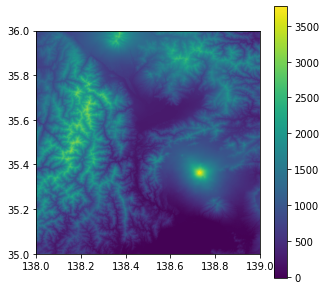

In [10]:
src = rio.open(url)
d = src.read(1)
fig, ax = plt.subplots(figsize=(5, 5))

# create a hidden image so we can add a colorbar
image_hidden = ax.imshow(d,cmap='viridis')

image = rio.plot.show(d, 
                      transform=src.transform, 
                      ax=ax, 
                      cmap='viridis')

fig.colorbar(image_hidden, ax=ax);